In [266]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import re
import os

In [239]:
df_path = '../../data/whisper-small-runs.csv'
df = pd.read_csv(df_path)
# only looking at first 10 epochs
df = df[(df['epoch'].isna()) | (df['epoch']<11)]
df.head()

C:\Users\marks\AppData\Local\Temp\ipykernel_19484\3805254241.py:2: DtypeWarning: Columns (4,6,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df_path)


,tag,value,experiment_name,step,preds_name,index,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch
0,test_loss,2.131800,whisper-small,0,whisper-small/tira-en+sw-test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,test_model_preparation_time,0.002300,whisper-small,0,whisper-small/tira-en+sw-test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,test_wer,0.798058,whisper-small,0,whisper-small/tira-en+sw-test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,test_mer,0.661401,whisper-small,0,whisper-small/tira-en+sw-test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,test_wil,0.823157,whisper-small,0,whisper-small/tira-en+sw-test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Tabulate baseline metrics

In [240]:
baseline_mask = df['experiment_name']=='whisper-small'
df.loc[
    (baseline_mask)&
    df['preds_name'].str.contains('tira'),
    'dataset'
] = 'tira-cs'
df.loc[
    (baseline_mask)&
    df['preds_name'].str.contains('zulu'),
    'dataset'
] = 'sasoc-cs'
df.loc[baseline_mask, 'preds_name']
df.loc[baseline_mask, 'lang_prompt']=df.loc[baseline_mask, 'preds_name'].apply(
    lambda s: re.match(
        r'whisper-small/(?:tira|zulu)-([^-]+)(-test)?',
        s.replace('en-sw', 'en+sw')
    ).groups()[0])
baseline_df = df[baseline_mask].pivot_table(index=['dataset', 'lang_prompt'], columns='tag', values='value', aggfunc=lambda x:x[~x.isna()].item())
# baseline_df[['test_cer_processed', 'test_wer_processed']]
baseline_df.columns.tolist()

['eval_cer',
 'eval_cer_processed',
 'eval_eng2eng_char_substitution_rate',
 'eval_eng2eng_char_substitution_rate_processed',
 'eval_eng2eng_char_substitutions',
 'eval_eng2eng_char_substitutions_processed',
 'eval_eng2eng_substitution_rate',
 'eval_eng2eng_substitution_rate_processed',
 'eval_eng2eng_substitutions',
 'eval_eng2eng_substitutions_processed',
 'eval_eng2misc_char_substitution_rate',
 'eval_eng2misc_char_substitution_rate_processed',
 'eval_eng2misc_char_substitutions',
 'eval_eng2misc_char_substitutions_processed',
 'eval_eng2misc_substitution_rate',
 'eval_eng2misc_substitution_rate_processed',
 'eval_eng2misc_substitutions',
 'eval_eng2misc_substitutions_processed',
 'eval_eng2tira_char_substitution_rate',
 'eval_eng2tira_char_substitution_rate_processed',
 'eval_eng2tira_char_substitutions',
 'eval_eng2tira_char_substitutions_processed',
 'eval_eng2tira_substitution_rate',
 'eval_eng2tira_substitution_rate_processed',
 'eval_eng2tira_substitutions',
 'eval_eng2tira_su

In [241]:
df.loc[[153,344],'lang_prompt']

153    en+sw
344       en
Name: lang_prompt, dtype: object

# Metadata

In [260]:
# get more detailed colnames
metrics = ['cer_processed', 'wer_processed', 'cer', 'wer']
def get_metric(s):
    for m in metrics:
        if m in s:
            return m
    return ''
df['metric']=df['tag'].apply(get_metric)
# df.loc[df['tag'].str.contains('test'),'metric']=''
df['metric'].value_counts()

metric
                 77487
wer               2233
cer               2233
wer_processed     1644
cer_processed     1644
Name: count, dtype: int64

In [243]:
# get eval dataset for each row
unique_datasets = ['fl_en', 'HH20210312', 'HH20210913', 'tira-clean-split', 'sasoc-cs', 'sasoc-zul', 'sasoc-en', 'nchlt_zul', 'nchlt_eng', 'tira_cs']

def get_dataset(s):
    for dataset in unique_datasets:
        if dataset in s:
            return dataset


df['dataset']=df['tag'].apply(get_dataset)
# ignore FLEURS and NCHLT
df=df[~df['dataset'].isin(['fl_en', 'nchlt_zul'])]
df.loc[
    df['experiment_name'].str.contains('tira')&df['dataset'].isna(),
    'dataset'
] = 'tira-cs'
df.loc[
    (df['experiment_name'].str.contains('zulu'))&df['dataset'].isna(),
    'dataset'
] = 'sasoc-cs'
df.loc[
    (df['preds_name'].fillna('').str.contains('tira')),
    'dataset'
] = 'tira-cs'
df.loc[
    (df['preds_name'].fillna('').str.contains('zulu')),
    'dataset'
] = 'sasoc-cs'
df['dataset'].value_counts(), df['dataset'].isna().sum()

(dataset
 tira-cs     43919
 sasoc-cs    41322
 Name: count, dtype: int64,
 0)

In [244]:
# so we can compare no LID loss to using LID loss
df['lid_loss_alpha']=df['lid_loss_alpha'].fillna(0)
df['ewc_lambda']=df['ewc_lambda'].fillna(0)

In [245]:
# make column "regularization"
df['ewc']=df['ewc_lambda']>0
df['lid_loss']=df['lid_loss_alpha']>0
df['regularization']='none'
df.loc[df['ewc'], 'regularization']='ewc'
df.loc[df['lid_loss'], 'regularization']='lid_loss'
df.loc[df['ewc'] & df['lid_loss'], 'regularization']='ewc+lid_loss'

In [246]:
# infer train data used from experiment name
df['train_data']='tira'
df.loc[df['experiment_name'].str.contains('tira-eng'), 'train_data']='tira-eng'
df.loc[df['experiment_name'].str.contains('tira-eng-50pct'), 'train_data']='tira-eng-50pct'
df.loc[df['experiment_name'].str.contains('tira-eng-cs'), 'train_data']='misc'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-20-80-small'), 'train_data']='tira-eng-cs-20-80-small'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-20-80-large'), 'train_data']='tira-eng-cs-20-80-large'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-50-50-large'), 'train_data']='tira-eng-cs-50-50'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-clean'), 'train_data']='tira-eng-cs-clean'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-long'), 'train_data']='tira-eng-cs-long'
df.loc[df['experiment_name'].str.contains('tira-all'), 'train_data']='tira-all'
df.loc[df['experiment_name'].str.contains('tira-all-clean'), 'train_data']='tira-all-clean'
df.loc[df['experiment_name'].str.contains('tira-all-long'), 'train_data']='tira-all-long'

df.loc[df['experiment_name'].str.contains('zulu'), 'train_data']='zulu'
df.loc[df['experiment_name'].str.contains('zulu-swahili-eng'), 'train_data']='zulu+eng'
df.loc[df['experiment_name'].str.contains('zulu-swahili-eng-50pct'), 'train_data']='zulu+eng-50pct'
df.loc[df['experiment_name'].str.contains('zulu-eng-cs'), 'train_data']='zulu-eng-cs'
df.loc[df['experiment_name'].str.contains('zulu-eng-all'), 'train_data']='zulu-eng-all'

df['train_data'].value_counts()

train_data
tira                 12398
zulu-eng-cs           9308
zulu-eng-all          9133
zulu+eng-50pct        8780
zulu+eng              8677
tira-eng-cs-clean     8366
tira-eng-cs-long      8016
tira-all-clean        7986
tira-eng              6824
zulu                  5032
tira-eng-50pct         520
tira-all-long          201
Name: count, dtype: int64

In [247]:
# df=df.sort_values('step')
# for experiment in df['experiment_name'].unique():
#     for tag in df['tag'].unique():
#         if 'loss' not in tag:
#             continue
#         loss_mask = df['tag']==tag
#         experiment_mask = df['experiment_name']==experiment
#         loss_diff = np.diff(df.loc[experiment_mask&loss_mask, 'value'])
#         loss_diff = np.insert(loss_diff, 0, 0)
#         df.loc[experiment_mask&loss_mask, 'loss_diff']=loss_diff
# df.head()


# Line plots

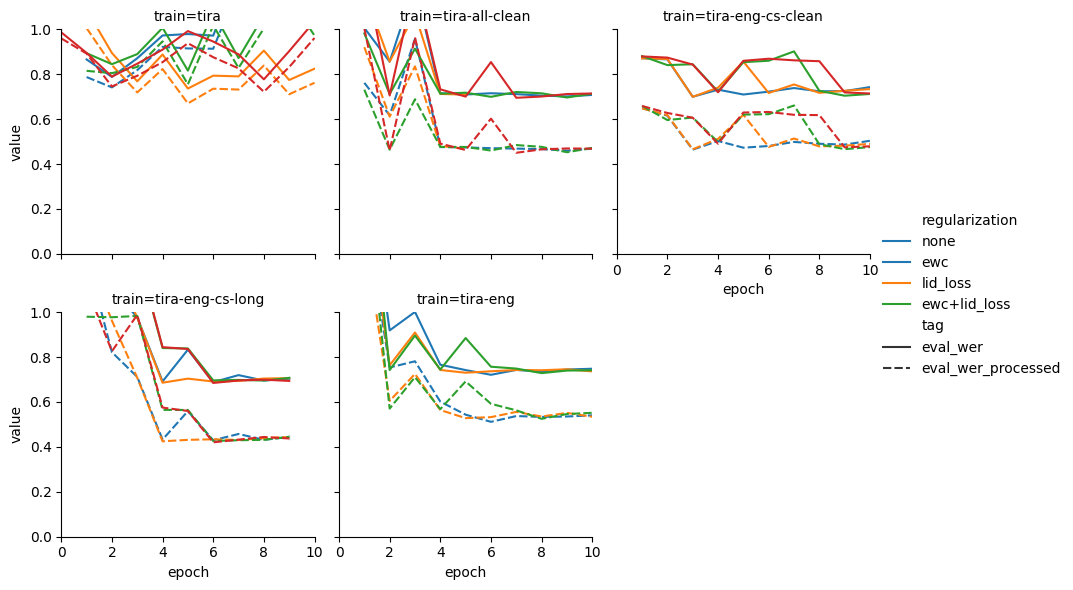

In [248]:
df['beam']=df['beam'].fillna(0).astype(float)
df['lm_alpha']=df['lm_alpha'].astype(str)
g = sb.FacetGrid(
    df[
        # (df['experiment_name'].str.contains('zulu')) &
        # ~(df['experiment_name'].str.contains('zulu-swahili-eng')) &
        (df['experiment_name'].str.contains('tira')) &
        # (~df['train_data'].str.contains('20-80'))&
        # (~df['train_data'].str.contains('misc'))&
        # (df['train_data'].str.contains('zulu-eng'))&
        # (df['train_data']!='tira-all')&
        # (df['lang_prompt']=='swahili') &
        # (df['lang_prompt']=='croatian')&
        # (df['dataset'].isin(['fl_en', 'tira-clean-split', 'sasoc-cs', 'nchlt_zul'])) &
        (df['dataset'].isin(['sasoc-cs', 'tira-cs'])) &
        (df['ewc_lambda'].isin([0,1])) &
        (df['lid_loss_alpha'].isin([0,0.2])) &
        # (df['beam']==2)&
        (df['beam']==0)&
        (~df['csv_name'].isna())&
        # (df['pred_name'].isna())&
        # (df['regularization']=='none')&
        # (df['tag'].str.contains('loss'))
        # (df['tag']=='train/loss')
        (df['tag'].isin(['eval_wer', 'eval_wer_processed']))
        # (df['metric']!='')
        # (df['LoRA'])
    ],
    # col='ewc_lambda',
    col='train_data',
    col_wrap=3,
    # row='lm_alpha',
    # col='lid_loss_alpha',
    # row='beam',
    # row='dataset',
    # sharey=False,
)
palette_map= {
    key: color for key, color in
    zip(['lid_loss', 'none', 'ewc', 'ewc+lid_loss'], sb.color_palette('husl',4))
}
g.map_dataframe(
    sb.lineplot,
    x='epoch',
    # x='step',
    y='value',
    # y='loss_diff',
    # hue='lid_loss_alpha',
    hue='regularization',
    # palette=palette_map,
    # hue='ewc_lambda',
    # errorbar=None,
    legend='full',
    style='tag',
    # style='tag',
)
# g.set_titles('eval={row_name}, train={col_name}')
g.set_titles('train={col_name}')
g.add_legend()
# g.set_title('Performance on English while decoding as Yoruba')
g.set(ylim=(0,1))
g.set(xlim=(0,10))
plt.show()

# Get best checkpoints for each model

In [259]:
lang_metrics = []
for metric in ['cer', 'wer']:
    for lang in ['eng', 'tira', 'zulu', 'misc']:
        lang_metrics.append(f"{lang}_{metric}")
has_lang_metric = lambda s: any(m in s for m in lang_metrics)
no_lang_metric_mask = ~df['tag'].apply(has_lang_metric)
df.loc[(df['metric']!='')&no_lang_metric_mask,'tag'].unique()

array(['test_wer', 'test_cer', 'eval_wer', 'eval_cer',
       'eval_wer_processed', 'eval_cer_processed',
       'eval/tira_eval-en+sw_cer', 'eval/tira_eval-en+sw_wer', 'eval/cer',
       'eval/wer', 'eval/sasoc-cs-en+sw_cer', 'eval/sasoc-cs-en+sw_wer',
       'test_wer_processed', 'test_cer_processed'], dtype=object)

In [271]:
df['best_checkpoint']=False
epoch_past_0 = df['epoch']>0
with open('best_checkpoint.csv', 'wb') as f:
    for exp in df['experiment_name'].unique():
        exp_mask = df['experiment_name']==exp
        if 'tira' in exp:
            # use `wer_processed` as metric, coming from checkpoints-eval.csv
            wer_processed_mask = df['metric']=='wer_processed'
            sorted_df = df[exp_mask&epoch_past_0&wer_processed_mask].sort_values('metric')
        elif 'zul' in exp:
            # use `wer` as metric, coming from TB runs
            wer_mask = df['metric']=='wer'
            sorted_df = df[exp_mask&epoch_past_0&wer_mask].sort_values('metric')
        if len(sorted_df)==0:
            continue
        best_epoch = sorted_df.iloc[0]['epoch']
        epoch_mask = df['epoch']==best_epoch
        df.loc[exp_mask&epoch_past_0&epoch_mask,'best_checkpoint']=True

        dataset_path = '/home/mjsimmons/datasets/tira_eval' if 'tira' in exp else\
        '/home/mjsimmons/datasets/sasoc-cs'
        model_path = '/mnt/LocalStorage/mjsimmons/'+exp
        checkpoint = f"checkpoint-{sorted_df.iloc[0]['step']}"
        lang='tira' if 'tira' in exp else 'zulu'
        f.write(bytes(','.join([model_path,checkpoint,dataset_path,lang])+'\n', encoding='utf8'))

df['best_checkpoint'].value_counts()


best_checkpoint
False    77308
True      7933
Name: count, dtype: int64

# Make table showing baseline and final test results: overall & lang specific

In [265]:
tira_metrics = []
for metric in ['_wer_processed', '_cer_processed']:
    tira_metrics.append('test'+metric)
for metric in ['_hit_rate_processed', '_char_hit_rate_processed']:
    for lang in ['tira', 'eng']:
        tira_metrics.append(f"test_{lang}{metric}")

df.loc[
    (df['dataset']=='tira-cs')&
    (df['tag'].isin(tira_metrics))
    # (df['tag'].str.contains('test'))
].pivot_table(
    columns='tag', index=['train_data', 'regularization', 'epoch'], values='value'
)

tag                                     test_cer_processed  \
train_data        regularization epoch                       
tira              ewc            5.0              0.267496   
                  ewc+lid_loss   8.0              0.279200   
                  lid_loss       2.0              0.269579   
                  none           2.0              0.259751   
tira-all-clean    ewc+lid_loss   7.0              0.355503   
                  lid_loss       9.0              0.344250   
                  none           9.0              0.352273   
tira-eng          ewc            6.0              0.298371   
                  none           8.0              0.314451   
tira-eng-cs-clean ewc            3.0              0.322405   
                  none           3.0              0.322995   

tag                                     test_eng_char_hit_rate_processed  \
train_data        regularization epoch                                     
tira              ewc            5.0                            0.787492   
                  ewc+lid_loss   8.0                            0.777706   
                  lid_loss       2.0                            0.756951   
                  none           2.0                            0.772159   
tira-all-clean    ewc+lid_loss   7.0                            0.863563   
                  lid_loss       9.0                            0.864316   
                  none           9.0                            0.870785   
tira-eng          ewc            6.0                            0.862375   
                  none           8.0                            0.864151   
tira-eng-cs-clean ewc            3.0                            0.868159   
                  none           3.0                            0.868200   

tag                                     test_eng_hit_rate_processed  \
train_data        regularization epoch                                
tira              ewc            5.0                       0.701148   
                  ewc+lid_loss   8.0                       0.693624   
                  lid_loss       2.0                       0.670256   
                  none           2.0                       0.688070   
tira-all-clean    ewc+lid_loss   7.0                       0.788717   
                  lid_loss       9.0                       0.789507   
                  none           9.0                       0.796498   
tira-eng          ewc            6.0                       0.784876   
                  none           8.0                       0.787050   
tira-eng-cs-clean ewc            3.0                       0.797941   
                  none           3.0                       0.797830   

tag                                     test_tira_char_hit_rate_processed  \
train_data        regularization epoch                                      
tira              ewc            5.0                             0.787697   
                  ewc+lid_loss   8.0                             0.783775   
                  lid_loss       2.0                             0.767198   
                  none           2.0                             0.772671   
tira-all-clean    ewc+lid_loss   7.0                             0.780148   
                  lid_loss       9.0                             0.777302   
                  none           9.0                             0.778428   
tira-eng          ewc            6.0                             0.755754   
                  none           8.0                             0.759485   
tira-eng-cs-clean ewc            3.0                             0.734625   
                  none           3.0                             0.734733   

tag                                     test_tira_hit_rate_processed  \
train_data        regularization epoch                                 
tira              ewc            5.0                        0.337912   
                  ewc+lid_loss   8.0                        0.

In [255]:
zero_as_baseline = df.copy()
zero_as_baseline.loc[(df['epoch']==0)&(df['train_data'].str.contains('tira')),'train_data']='tira baseline'
zero_as_baseline.loc[(df['epoch']==0)&(df['train_data'].str.contains('zulu')),'train_data']='zulu baseline'
metric_cols = zero_as_baseline[
    # (df['metric']!='')&
    (df['epoch']<=10)&
    # (df['epoch']>1)&
    # (((~df['preds_name'].isna())|(~df['csv_name'].isna()))|(df['epoch']==0)) &
    (~(df['tag']).str.contains('test')) &
    # (~(df['tag']).str.contains('processed')) &
    (df['dataset'].isin(['sasoc-cs', 'tira-cs'])) &
    no_lang_metric_mask
].pivot_table(
    columns=['regularization'],
    values=['value'],
    index=['train_data', 'epoch', 'metric'],
    aggfunc=lambda x:x.min(),
).pivot_table(
    index=['train_data', 'epoch'],
    columns=['metric'],
).droplevel(
    axis=1,
    level=0
)
reg_names = ['none', 'ewc', 'lid_loss', 'ewc+lid_loss']
reg_dfs = []
for reg in reg_names:
    reg_df=metric_cols[reg]
    reg_df=reg_df.sort_values('wer')
    reg_df=reg_df.reset_index()
    reg_df=reg_df.rename_axis('', axis=1)
    # reg_df=reg_df[reg_df['epoch']>0]
    reg_df=reg_df.drop_duplicates(subset=['train_data'], keep='first')
    reg_df['regularization']=reg
    reg_dfs.append(reg_df)
reg_dfs = pd.concat(reg_dfs)
table=reg_dfs.melt(
    value_vars=['cer', 'wer', 'epoch'],
    var_name='var',
    id_vars=['train_data', 'regularization']
).sort_values(
    'train_data'
).pivot_table(
    columns=['regularization', 'var'],
    index='train_data'
)
table.columns.names=[None,'regularization',None]
table=table.droplevel(0,axis=1)
table=table.reset_index()
is_tira=table['train_data'].str.contains('tira')
table = pd.concat({'Tira': table[is_tira], 'Zulu': table[~is_tira]})
table=table.rename({
    'ewc': 'EWC',
    'lid_loss': 'LID loss',
    'none': 'Plain finetune',
    'ewc+lid_loss': 'EWC+LID loss',
    'train_data': 'Train dataset',
}, axis=1)
table['Train dataset']=table['Train dataset'].map({
    'tira': 'Mono',
    'tira-all-clean': 'All (short)',
    'tira-all-long': 'All (long)',
    'tira-eng': 'Biling',
    'tira-eng-50pct': 'Biling (50\\%)',
    'tira-eng-cs-clean': "CS (short)",
    'tira-eng-cs-long': "CS (long)",
    'tira baseline': 'Baseline',
    'zulu': "Mono",
    'zulu+eng': "Biling",
    'zulu+eng-50pct': "Biling (50\\%)",
    'zulu-eng-all': 'All',
    'zulu-eng-cs': 'CS',
    'zulu baseline': 'Baseline',
})

for column in table.columns:
    if column[1]=='epoch':
        table[column]=table[column].astype(int)
    elif column[1]=='':
        pass
    elif column[1] in ('wer', 'cer'):
        table[column]=table[column].apply(lambda n:f"{n:.2f}")
for language in ['Tira', 'Zulu']:
    is_language = table.index.get_level_values(0)==language
    for column in table.columns:
        if column[1] in ('wer', 'cer'):
            min_idx = table.loc[language,column].astype(float).idxmin()
            min_val = table.at[(language,min_idx),column]
            table.loc[(is_language)&(table[column]==min_val),column]=r'\textbf{'+min_val+r'}'
split_bf = lambda s:s.removeprefix(r'\textbf{').removesuffix(r'}')
def italicize_min_per_row(row):
    if row['Train dataset'].item() == 'Baseline':
        return row
    cer = row.index.get_level_values(1)=='cer'
    min_cer_idx = row[cer].apply(split_bf).astype(float).idxmin()
    min_cer_value=row[min_cer_idx]
    row[cer&(row==min_cer_value)]=r'\textit{'+min_cer_value+r'}'

    wer = row.index.get_level_values(1)=='wer'
    min_wer_idx = row[wer].apply(split_bf).astype(float).idxmin()
    min_wer_value=row[min_wer_idx]
    row[wer&(row==min_wer_value)]=r'\textit{'+min_wer_value+r'}'
    return row
table=table.apply(italicize_min_per_row, axis=1)
table=table.loc[:,table.columns.get_level_values(1)!='epoch']
table=pd.concat({
    'Tira':table.loc['Tira'].set_index('Train dataset'),
    'Zulu':table.loc['Zulu'].set_index('Train dataset'),
})
table.columns.names=None,None
ordered_cols = []
for reg in ['Plain finetune', 'EWC', 'LID loss', 'EWC+LID loss']:
    for metric in ['wer', 'cer']:
        ordered_cols.append((reg,metric))
table=table[ordered_cols]
ordered_rows = []
for ds in ['Baseline', 'Mono', 'Biling', 'Biling (50\%)', 'CS (short)', 'CS (long)', 'All (short)', 'All (long)']:
# for ds in ['Baseline', 'Mono', 'All (short)', 'CS', 'Biling']:
    ordered_rows.append(('Tira', ds))
for ds in ['Baseline', 'Mono', 'Biling', 'Biling (50\%)', 'CS', 'All']:
    ordered_rows.append(('Zulu', ds))
table=table.loc[ordered_rows]
table

Plain finetune                 \
                                       wer            cer   
     Train dataset                                          
Tira Baseline                         0.64           0.51   
     Mono                             0.74           0.67   
     Biling                           0.73           0.53   
     Biling (50\%)           \textit{0.71}           0.49   
     CS (short)              \textit{0.46}  \textit{0.35}   
     CS (long)               \textbf{0.43}  \textbf{0.34}   
     All (short)                      0.46           0.35   
     All (long)                        nan            nan   
Zulu Baseline                         1.49           0.92   
     Mono                             0.84           0.47   
     Biling                           0.58           0.28   
     Biling (50\%)                    0.63  \textit{0.32}   
     CS                               0.46           0.22   
     All            \textit{\textbf{0.39}}  \textbf{0.18}   

                                       EWC                          \
                                       wer                     cer   
     Train dataset                                                   
Tira Baseline                         0.64                    0.51   
     Mono                    \textit{0.67}           \textit{0.58}   
     Biling                  \textit{0.51}           \textit{0.45}   
     Biling (50\%)           \textit{0.71}           \textit{0.48}   
     CS (short)                       0.47           \textit{0.35}   
     CS (long)      \textit{\textbf{0.42}}  \textit{\textbf{0.33}}   
     All (short)                      0.47                    0.36   
     All (long)                        nan                     nan   
Zulu Baseline                         1.49                    0.92   
     Mono                    \textit{0.66}           \textit{0.34}   
     Biling                           0.70                    0.41   
     Biling (50\%)                    0.62                    0.35   
     CS                               0.44                    0.21   
     All            \textit{\textbf{0.39}}           \textbf{0.18}   

                                  LID loss                          \
                                       wer                     cer   
     Train dataset                                                   
Tira Baseline                         0.64                    0.51   
     Mono                             0.76                    0.64   
     Biling                           0.53           \textit{0.45}   
     Biling (50\%)           \textit{0.71}           \textit{0.48}   
     CS (short)                       0.47           \textit{0.35}   
     CS (long)               \textbf{0.43}  \textit{\textbf{0.33}}   
     All (short)             \textit{0.45}                    0.34   
     All (long)                        nan                     nan   
Zulu Baseline                         1.49                    0.92   
     Mono                             0.70           \textit{0.34}   
     Biling                           0.56           \textit{0.26}   
     Biling (50\%)           \textit{0.61}                    0.33   
     CS                               0.45                    0.21   
     All            \textit{\textbf{0.39}}  \textit{\textbf{0.17}}   

                              EWC+LID loss                          
                                       wer                     cer  
     Train dataset                                                  
Tira Baseline                         0.64                    0.51  
     Mono                             0.72                    0.65  
     Biling                           0.53                    0.46  
     Biling (50\%)           \textit{0.71}           \textit{0.48}  
     CS (short)                       0.47           \textit{0.35}  
     CS (long)      \textit{\textbf{0.42}}  \textit{\tex

In [256]:
df['train_data'].unique()

array(['tira', 'tira-all-clean', 'tira-all-long', 'tira-eng',
       'tira-eng-50pct', 'tira-eng-cs-clean', 'tira-eng-cs-long',
       'zulu-eng-all', 'zulu-eng-cs', 'zulu', 'zulu+eng',
       'zulu+eng-50pct'], dtype=object)

In [257]:
with open('table.tex', 'w') as f:
    latex_str=table.to_latex(index=True, escape=False, sparsify=True, multirow=False)
    latex_str=latex_str.replace(r'\multicolumn{2}{r}', r'\multicolumn{2}{l}')
    latex_str=latex_str.replace('Zulu','\midrule\nisiZulu')
    f.write(latex_str)